<a href="https://colab.research.google.com/github/MohitNaren/ML/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wcukierski_enron_email_dataset_path = kagglehub.dataset_download('wcukierski/enron-email-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'enron-email-dataset' dataset.
Data source import complete.


**Imports & Setup**

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

# NLP preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF, PCA
from sklearn.decomposition import TruncatedSVD


# Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score
import nltk
nltk.download('stopwords')


# Setup
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Load & Inspect Data**

In [ ]:
import os

dataset_path = '/kaggle/input/enron-email-dataset'
print("Files in dataset folder:", os.listdir(dataset_path))

# Replace with the correct CSV name
df = pd.read_csv(os.path.join(dataset_path, 'emails.csv'))
df.head()

Files in dataset folder: ['emails.csv']


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


**Preprocessing Functions**

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Vectorized cleaning
df['cleaned'] = (
    df['message']
    .astype(str)
    .str.lower()  # lowercase
    .str.replace(r'\S*@\S*\s?', '', regex=True)  # remove emails
    .str.replace(r'\s+', ' ', regex=True)        # remove extra spaces
    .str.replace(r'[^a-zA-Z ]', '', regex=True) # keep only letters
)

# Step 2: TF-IDF vectorization with built-in stopwords (faster)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned'])

print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (517401, 1000)


**Extra TF-IDF Visualization**

Subset shape: (2000, 1000)


/tmp/ipython-input-1099054043.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette='viridis')


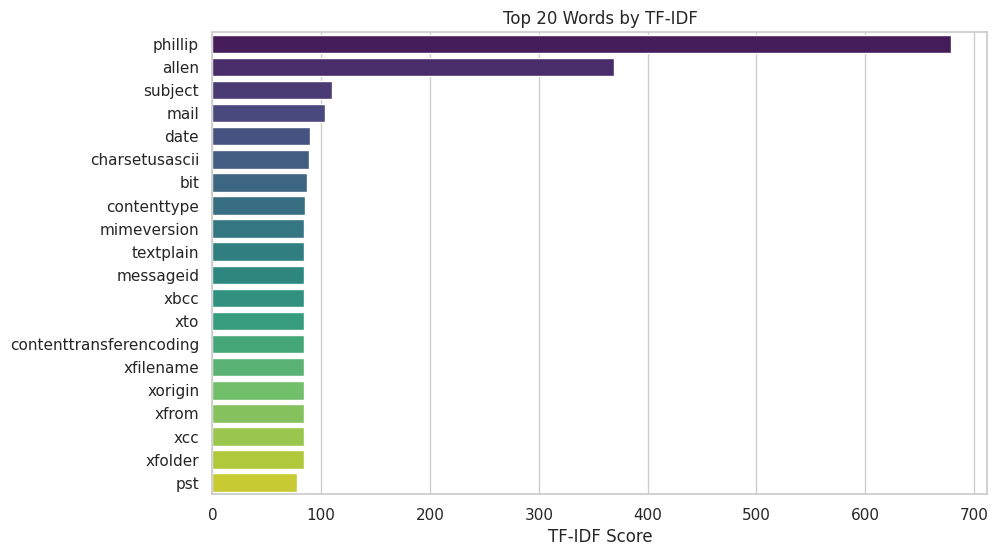

In [ ]:
# For faster testing, use first 2000 emails
X_small = X[:2000]
df_small = df[:2000].reset_index(drop=True)
print("Subset shape:", X_small.shape)
tfidf_sum = np.array(X_small.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[-20:][::-1]
top_words = np.array(vectorizer.get_feature_names_out())[top_indices]
top_scores = tfidf_sum[top_indices]

plt.figure(figsize=(10,6))
sns.barplot(x=top_scores, y=top_words, palette='viridis')
plt.title("Top 20 Words by TF-IDF")
plt.xlabel("TF-IDF Score")
plt.show()


**KMeans Clustering**

In [ ]:
# Use TruncatedSVD to reduce sparse matrix to 50 components
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_small)

# Optional: further reduce to 2D for plotting
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_reduced)

KMeans - Silhouette: 0.07233886602622142 Davies-Bouldin: 2.530270469518343


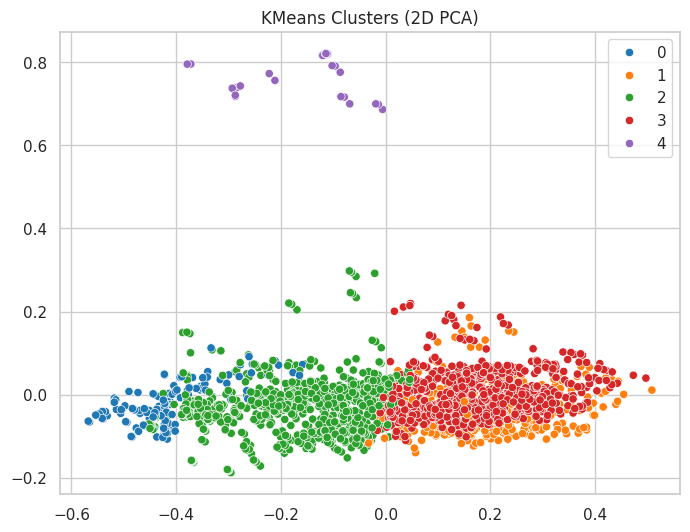

/tmp/ipython-input-1339514496.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x='cluster', palette='tab10')


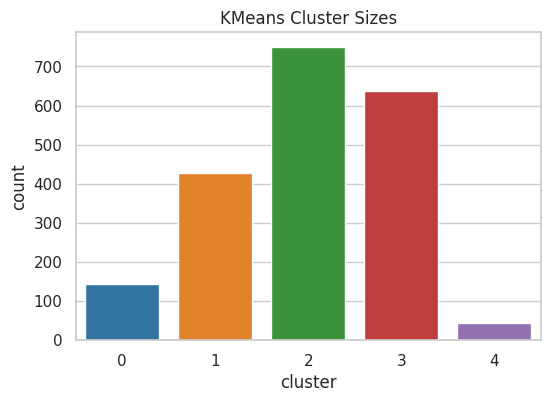

In [ ]:
k = 5  # number of clusters

# Fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=200)
labels_km = kmeans.fit_predict(X_reduced)  # use SVD-reduced matrix

# Metrics
sil_km = silhouette_score(X_reduced, labels_km)
db_km = davies_bouldin_score(X_reduced, labels_km)
print("KMeans - Silhouette:", sil_km, "Davies-Bouldin:", db_km)

# 2D PCA for plotting
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels_km, palette='tab10', legend='full')
plt.title("KMeans Clusters (2D PCA)")
plt.show()

# Cluster sizes
df_plot = pd.DataFrame({'cluster': labels_km})
plt.figure(figsize=(6,4))
sns.countplot(data=df_plot, x='cluster', palette='tab10')
plt.title("KMeans Cluster Sizes")
plt.show()

**Agglomerative Clustering**

Agglomerative - Silhouette: 0.0899288276436451 Davies-Bouldin: 2.504708900681586


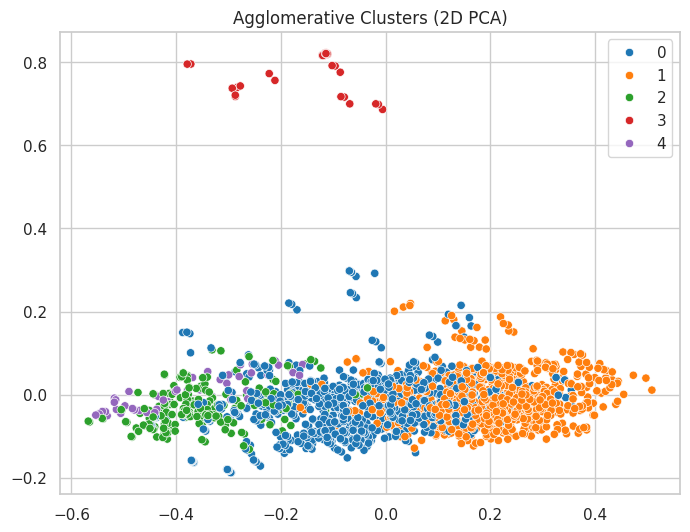

/tmp/ipython-input-3661007922.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_plot, x='cluster', palette='tab10')


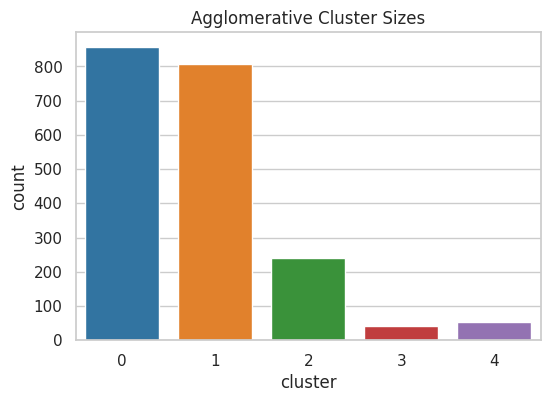

In [ ]:
k = 5  # number of clusters

# Fit Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=k)
labels_ag = agg.fit_predict(X_reduced)  # use SVD-reduced matrix

# Metrics
sil_ag = silhouette_score(X_reduced, labels_ag)
db_ag = davies_bouldin_score(X_reduced, labels_ag)
print("Agglomerative - Silhouette:", sil_ag, "Davies-Bouldin:", db_ag)

# 2D PCA for plotting
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_reduced)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=labels_ag, palette='tab10', legend='full')
plt.title("Agglomerative Clusters (2D PCA)")
plt.show()

# Cluster sizes
df_plot = pd.DataFrame({'cluster': labels_ag})
plt.figure(figsize=(6,4))
sns.countplot(data=df_plot, x='cluster', palette='tab10')
plt.title("Agglomerative Cluster Sizes")
plt.show()

**3D PCA Scatter - KMeans Clusters**

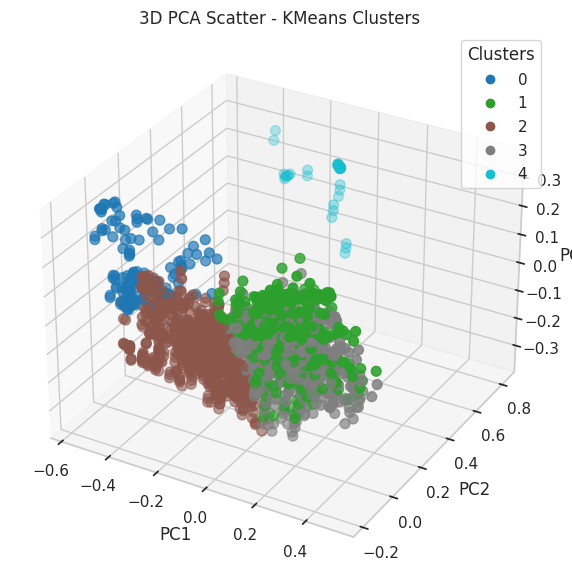

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3, random_state=42)
X_3d = pca_3d.fit_transform(X_reduced)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2],
                     c=labels_km, cmap='tab10', s=50)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Scatter - KMeans Clusters")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


**Silhouette Score vs K (KMeans)**

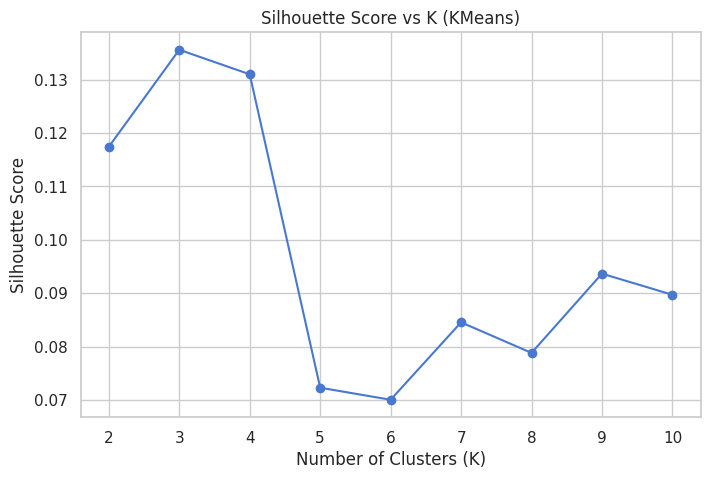

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
k_values = range(2, 11)  # try K=2 to K=10

for k_try in k_values:
    km = KMeans(n_clusters=k_try, random_state=42, n_init=5, max_iter=200)
    labels = km.fit_predict(X_reduced)
    sil_scores.append(silhouette_score(X_reduced, labels))

plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K (KMeans)")
plt.grid(True)
plt.show()
